# 🎓 Midterm Project — Student Performance Prediction

## 1. Project Overview

### 1.1 Problem Description

The goal of this project is to predict **students' academic performance** — specifically their **math, reading, and writing scores** — based on demographic and educational background factors such as gender, parental education level, lunch type, and test preparation course.

This predictive model can help educators identify students who may need additional support in specific subjects.

### 1.2 Dataset

* **Source:** [Kaggle - Students Performance in Exams](https://www.kaggle.com/datasets/spscientist/students-performance-in-exams)
* **Description:** The dataset contains demographic and test information of students, including:

  * Gender
  * Race/Ethnicity
  * Parental level of education
  * Lunch type
  * Test preparation course
  * Math score (target variable)
  * Reading score (target variable)
  * Writing score (target variable)




## 2. Data Preparation and Exploratory Data Analysis (EDA)

### 2.1 Import Libraries and Dataset

* Import essential libraries (Pandas, NumPy, Scikit-learn, Matplotlib, Seaborn)
* Load dataset and display first few rows using `head()`

### 2.2 Basic Inspection

* Check dataset shape, column names, and data types
* Look for missing values and duplicates
* Identify numerical and categorical features

### 2.3 Exploratory Visualization

* Histograms for score distributions
* Countplots for categorical variables (e.g., gender, parental education)
* Heatmap and Pairplots to explore target interactions

### 2.4 Feature Insights

* Discuss key trends:

  * Gender differences in performance
  * Impact of test preparation course
  * Parental education vs student performance


In [56]:
# 2.1

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

# import the relevant regressors
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

!pip install xgboost
import xgboost as xgb


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip


In [57]:
df = pd.read_csv('StudentsPerformance.csv')

In [58]:
# 2.2

print(df.head())

   gender race/ethnicity parental level of education         lunch  \
0  female        group B           bachelor's degree      standard   
1  female        group C                some college      standard   
2  female        group B             master's degree      standard   
3    male        group A          associate's degree  free/reduced   
4    male        group C                some college      standard   

  test preparation course  math score  reading score  writing score  
0                    none          72             72             74  
1               completed          69             90             88  
2                    none          90             95             93  
3                    none          47             57             44  
4                    none          76             78             75  


In [59]:
print(df.columns)

Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course', 'math score', 'reading score',
       'writing score'],
      dtype='object')


In [60]:
print(df.isna().any())

gender                         False
race/ethnicity                 False
parental level of education    False
lunch                          False
test preparation course        False
math score                     False
reading score                  False
writing score                  False
dtype: bool


In [61]:
print(df.dtypes)

gender                         object
race/ethnicity                 object
parental level of education    object
lunch                          object
test preparation course        object
math score                      int64
reading score                   int64
writing score                   int64
dtype: object


In [62]:
to_category = ['gender','race/ethnicity','parental level of education','lunch','test preparation course']
df[to_category] = df[to_category].astype('category')

parental_order = ["some high school", "high school", "some college", "associate's degree", "bachelor's degree", "master's degree"]
df['parental level of education'] = pd.Categorical(df['parental level of education'], categories=parental_order, ordered=True)

print(df.dtypes)

gender                         category
race/ethnicity                 category
parental level of education    category
lunch                          category
test preparation course        category
math score                        int64
reading score                     int64
writing score                     int64
dtype: object


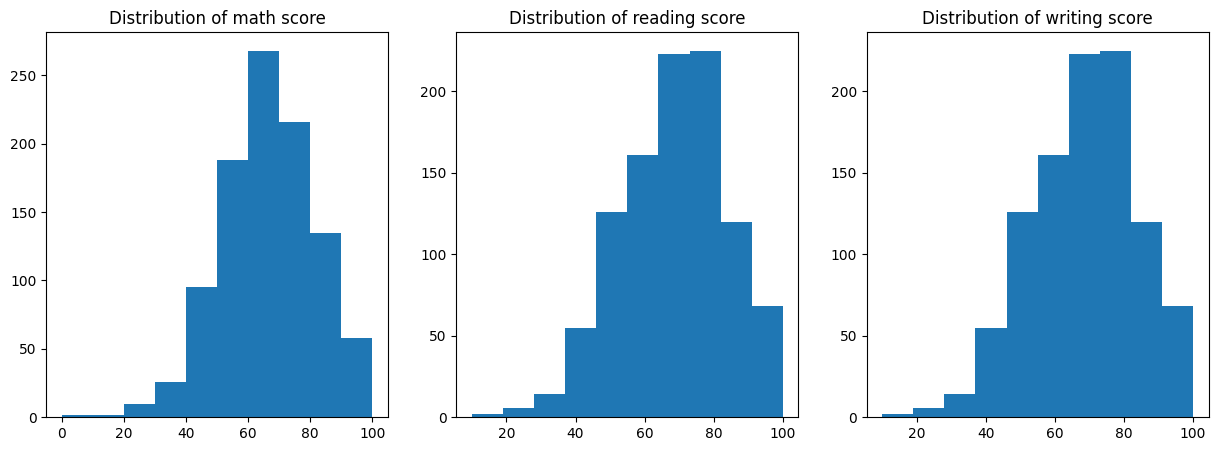

In [63]:
# 2.3

fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].hist(df['math score'])
ax[0].set_title('Distribution of math score')

ax[1].hist(df['writing score'])
ax[1].set_title('Distribution of reading score')

ax[2].hist(df['writing score'])
ax[2].set_title('Distribution of writing score')

plt.show()


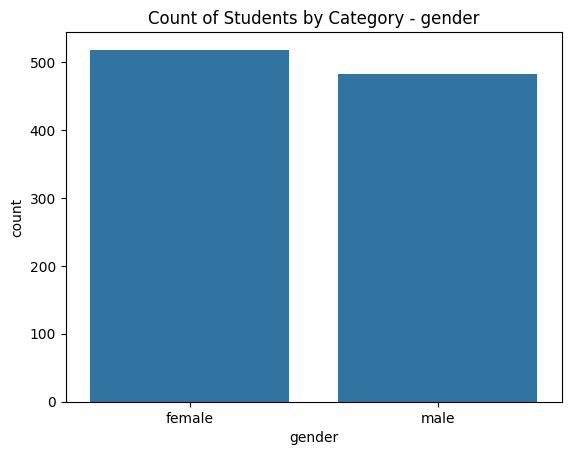

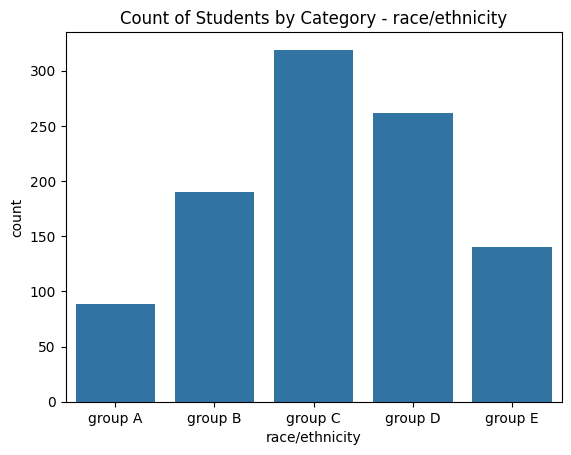

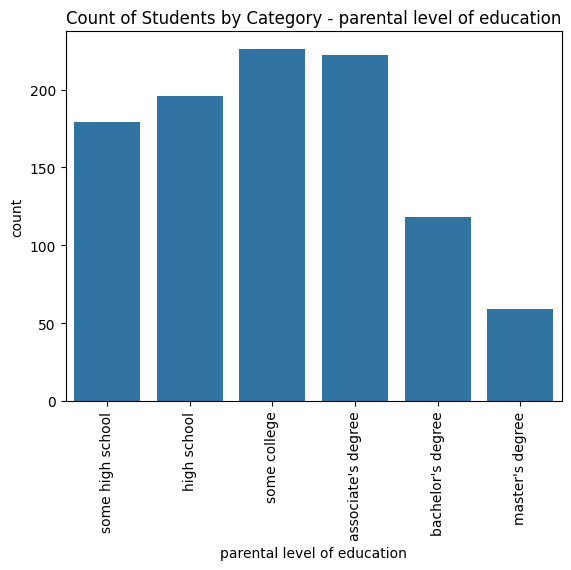

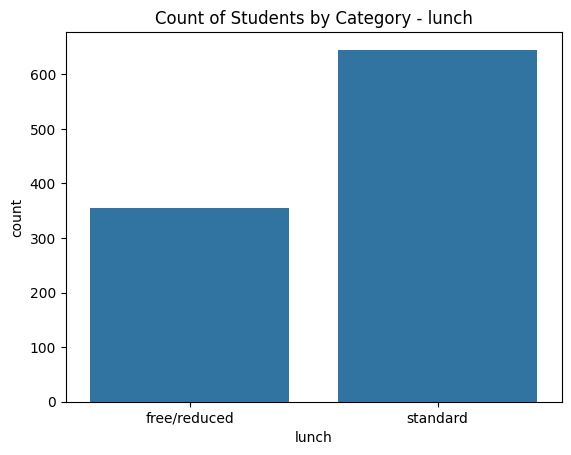

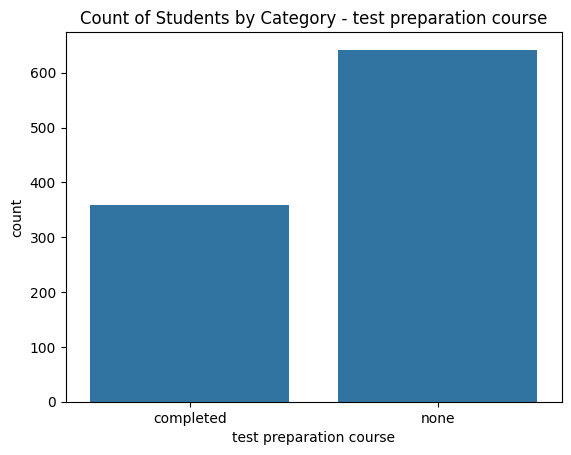

In [64]:
for i in to_category:
    sns.countplot(data=df, x=i)
    plt.title("Count of Students by Category - %s" % i)
    if i == 'parental level of education':
        plt.xticks(rotation=90)
    plt.show()

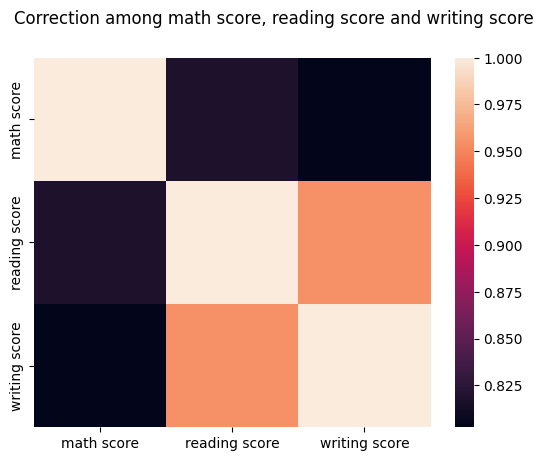

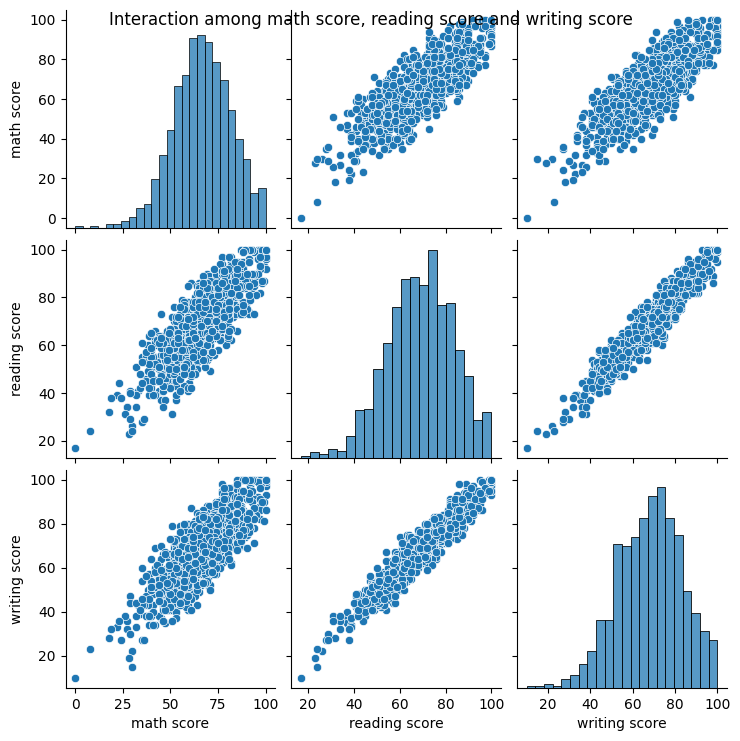

In [65]:
sns.heatmap(df[['math score','reading score','writing score']].corr())
plt.suptitle('Correction among math score, reading score and writing score')
plt.show()

sns.pairplot(df[['math score','reading score','writing score']])
plt.suptitle('Interaction among math score, reading score and writing score')
plt.show()

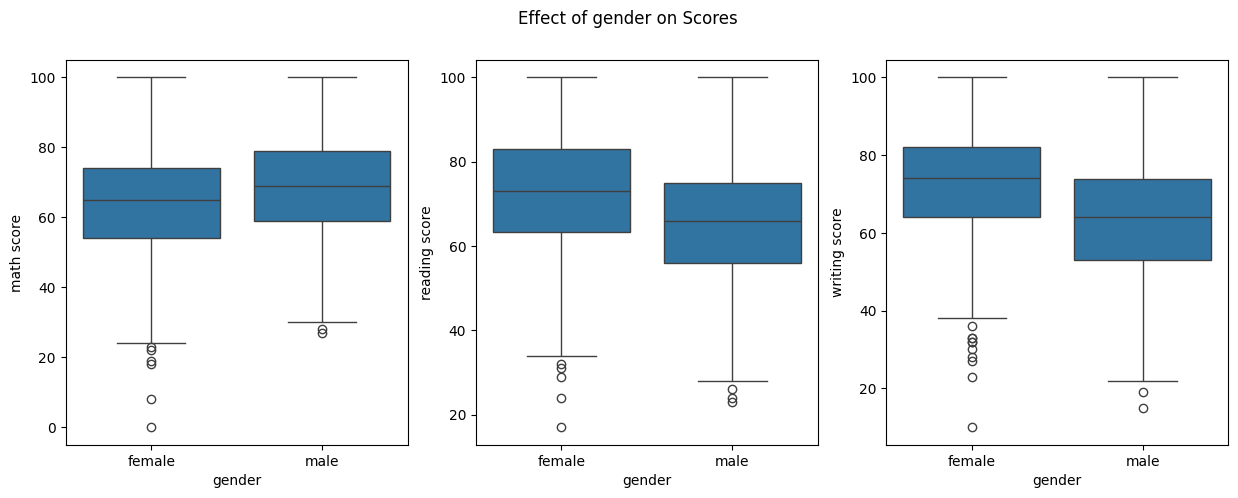

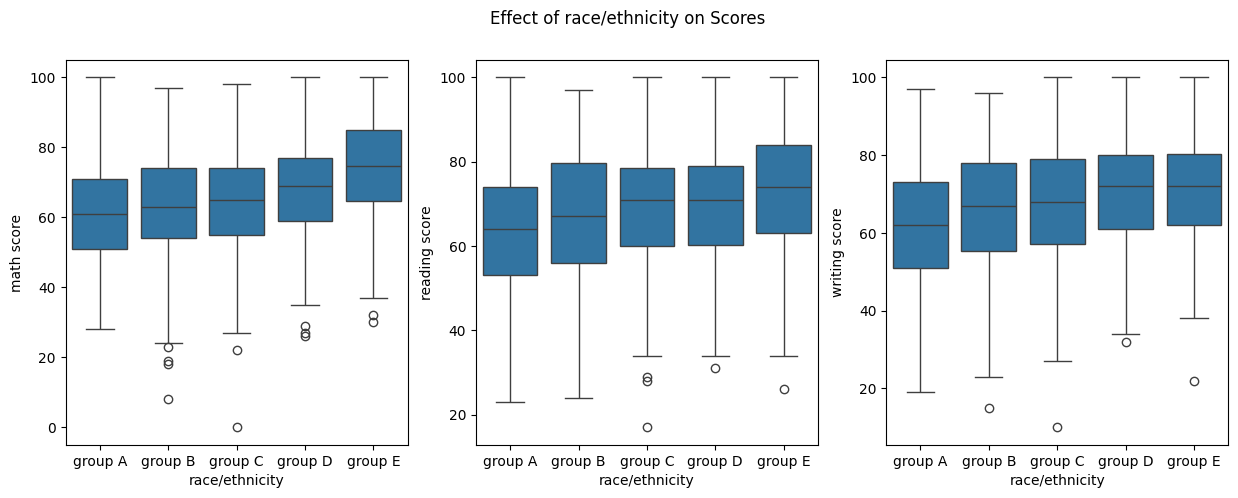

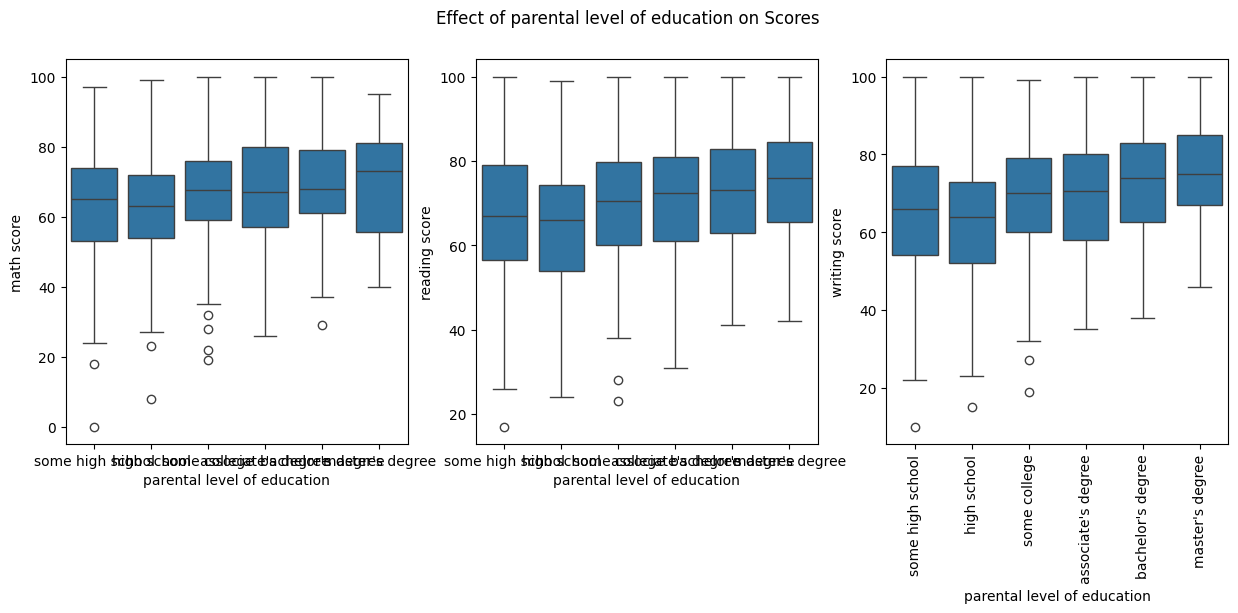

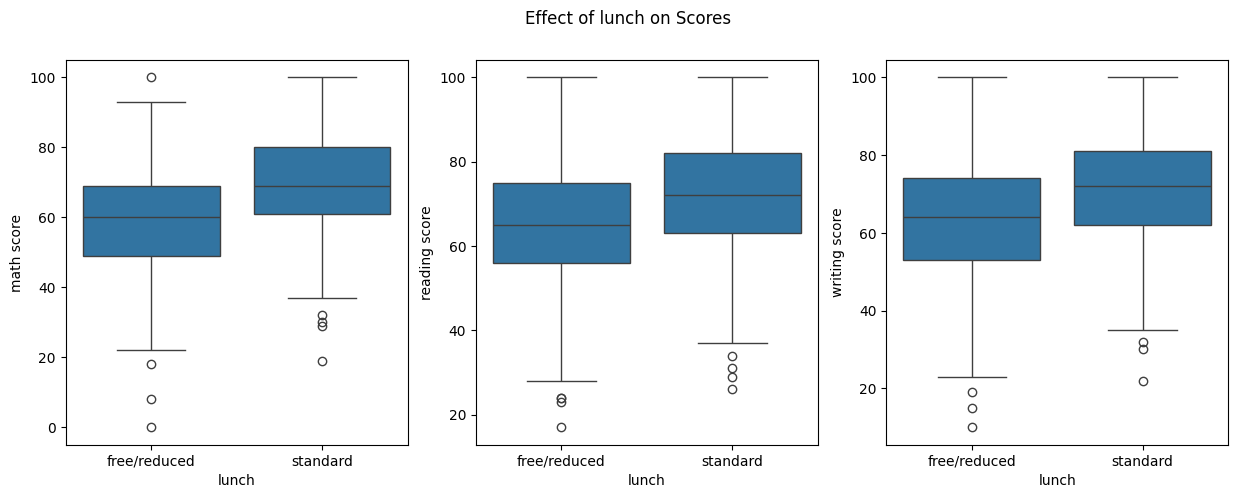

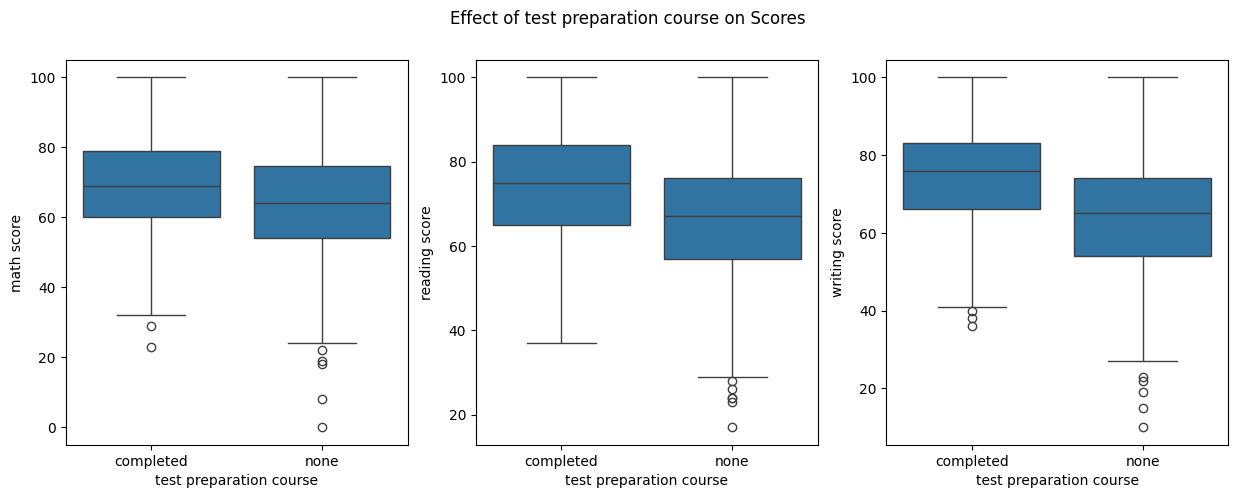

In [66]:
# 2.4

for cat in to_category:
    fig, ax = plt.subplots(1,3,figsize=(15,5))
    for i,d in enumerate(['math score', 'reading score', 'writing score']):
        sns.boxplot(x=cat, y=d, data=df, ax=ax[i])
        if cat == 'parental level of education':
            plt.xticks(rotation=90)
    plt.suptitle(f'Effect of {cat} on Scores')
    plt.show()

## 3. Data Preprocessing

### 3.1 Encoding Categorical Variables

* Apply one-hot encoding or label encoding where necessary.

### 3.2 Feature Scaling

* Apply standardization or normalization as appropriate.

### 3.3 Feature-Target Separation

* Define **X (input features)** and **y (targets)** — math, reading, and writing scores.

### 3.4 Train/Validation/Test Split

* Split dataset into training (60%), validation (20%), and test (20%).

In [67]:
# Check whether there is any missing data:

df.isna().sum()

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

In [68]:
# Split the dataset

df_all_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_all_train, test_size=0.25, random_state=42)

y_train = []
y_val = []
y_all_train = []
y_test = []

eval_cols = ['math score', 'reading score', 'writing score']

for e in eval_cols:
    y_train.append(df_train[e].values)
    y_val.append(df_val[e].values)
    y_all_train.append(df_all_train[e].values)
    y_test.append(df_test[e].values)

    del df_train[e]
    del df_val[e]
    del df_all_train[e]
    del df_test[e]

# Use Data Vectorizer
dv = DictVectorizer(sparse=True)

train_dict = df_train.to_dict(orient='records')
all_train_dict = df_all_train.to_dict(orient='records')
val_dict = df_val.to_dict(orient='records')
test_dict = df_test.to_dict(orient='records')

X_train = dv.fit_transform(train_dict)
X_all_train = dv.transform(all_train_dict)
X_val = dv.transform(val_dict)
X_test = dv.transform(test_dict)

# columns:
print(dv.get_feature_names_out())

['gender=female' 'gender=male' 'lunch=free/reduced' 'lunch=standard'
 "parental level of education=associate's degree"
 "parental level of education=bachelor's degree"
 'parental level of education=high school'
 "parental level of education=master's degree"
 'parental level of education=some college'
 'parental level of education=some high school' 'race/ethnicity=group A'
 'race/ethnicity=group B' 'race/ethnicity=group C'
 'race/ethnicity=group D' 'race/ethnicity=group E'
 'test preparation course=completed' 'test preparation course=none']



---

## 4. Model Training and Evaluation

### 4.1 Baseline Model

* Simple model such as mean prediction or linear regression baseline.

### 4.2 Lasso Regression

* Train Lasso Regression
* Tune hyperparameter `alpha` using grid search
* Evaluate with RMSE / R² metrics on validation set

### 4.3 Decision Tree Regressor

* Train Decision Tree model
* Tune `max_depth` and `min_samples_split`
* Evaluate and visualize feature importance

### 4.4 Random Forest Regressor

* Train Random Forest model
* Tune `n_estimators` and `max_depth`
* Compare validation performance and interpret feature importance

### 4.5 XGBoost Regressor

* Train and tune XGBoost model
* Evaluate metrics and analyze feature importance

### 4.6 Model Comparison

* Create summary table comparing all models on validation data (RMSE, R²)
* Select the **best-performing model**

---

## 5. Model Export and Scripting

### 5.1 Export Training Logic

* Move final training pipeline to `train.py`
* Save trained model (e.g., using `joblib` or `pickle`)

### 5.2 Prediction Script

* Implement `predict.py` to load model and perform inference on new data.

---

## 6. Model Deployment (Local)

### 6.1 Simple Web Service

* Create Flask or FastAPI endpoint to serve predictions (e.g., `/predict`)
* Test locally

### 6.2 Dockerization

* Write Dockerfile
* Run and test container locally (`docker build`, `docker run`)

### 6.3 Optional: Cloud Deployment

* (Optional) Deploy to cloud platform (e.g., Render, Railway, or Hugging Face Spaces)
* Include **URL** or **video screenshot** in README

---

## 7. Reproducibility and Environment Management

### 7.1 Dependency File

* Include `requirements.txt` or `Pipfile` listing all dependencies.

### 7.2 Virtual Environment Setup

```bash
python -m venv venv
source venv/bin/activate  # or venv\Scripts\activate on Windows
pip install -r requirements.txt
```

### 7.3 Execution Instructions

1. Clone this repository
2. Install dependencies
3. Run `train.py` to train the model
4. Run `predict.py` to test predictions
5. Start Flask/FastAPI app via `python predict.py`
6. (Optional) Build Docker image and deploy

---

## 8. Evaluation Summary (Aligned with Zoomcamp Rubric)

| Criterion             | Description                                 | Points                   |
| --------------------- | ------------------------------------------- | ------------------------ |
| Problem description   | Clearly defined with motivation and context | ✅ 2                      |
| EDA                   | Comprehensive with insights and visuals     | ✅ 2                      |
| Model training        | Multiple models with tuning                 | ✅ 3                      |
| Exporting to script   | `train.py` provided                         | ✅ 1                      |
| Reproducibility       | Runs cleanly with accessible data           | ✅ 1                      |
| Deployment            | Local web service (Flask/BentoML)           | ✅ 1                      |
| Dependency management | Requirements and environment setup          | ✅ 2                      |
| Containerization      | Dockerized with instructions                | ✅ 2                      |
| Cloud deployment      | Optional bonus (URL/video)                  | ✅ +2                     |
| **Total Possible**    |                                             | **16 points (+2 bonus)** |

---

## 9. Reflection and Next Steps

* Summarize findings and model performance
* Discuss key features influencing student performance
* Outline potential improvements (e.g., handling outliers, adding new data)
* Reflect on lessons learned from the project

---

## 10. References

* [Machine Learning Zoomcamp - Project Guidelines](https://github.com/DataTalksClub/machine-learning-zoomcamp/tree/master/projects)
* [Kaggle Dataset: Students Performance in Exams](https://www.kaggle.com/datasets/spscientist/students-performance-in-exams)
* [Scikit-learn Documentation](https://scikit-learn.org/stable/)
* [XGBoost Documentation](https://xgboost.readthedocs.io/)

# Applying Different Regression Models

In this section, we will train and evaluate several types of regression models:

- **Linear Regression**
- **Decision Tree Regressor**
- **Random Forest Regressor**
- **XGBoost Regressor**

The regression models' parameters will be tuned based on evaluation criteria **root mean squared error**

In [69]:
# Linear Regression (Lasso)

# For Math, Reading, Writing [0,1,2]:
lr = []
pred_lr = []
for i in range(3):
    lr.append(DecisionTreeRegressor())
    lr[i].fit(X_train, y_train[i])
    pred_lr.append(lr[i].predict(X_val))

In [70]:
# Decision Tree Regressor

# For Math, Reading, Writing [0,1,2]:
dt = []
pred_dt = []
for i in range(3):
    dt.append(DecisionTreeRegressor())
    dt[i].fit(X_train, y_train[i])
    pred_dt.append(dt[i].predict(X_val))

In [71]:
# Random Forest Regressor

# For Math, Reading, Writing [0,1,2]:
rf = []
pred_rf = []
for i in range(3):
    rf.append(RandomForestRegressor())
    rf[i].fit(X_train, y_train[i])
    pred_rf.append(dt[i].predict(X_val))

In [72]:
# XGBoost

etas = [1, 0.5, 0.3, 0.1, 0.05]
features = list(dv.get_feature_names_out())

for eta in etas:

    for i in range(3):
        
        dtrain = xgb.DMatrix(X_train, label=y_train[i], feature_names=features)
        dval = xgb.DMatrix(X_val, label=y_val[i], feature_names=features)

    
        xgb_params = {
            'eta': eta,
            'max_depth': 20,
            'min_child_weight': 1,
            
            'objective': 'reg:squarederror',
            'nthread': 8,
            
            'seed': 1,
            'verbosity': 1,
        }

        #model = xgb.train(
        #    xgb_params,
        #    dtrain,
        #    evals=watchlist,
        #    verbose_eval=0,
        #    num_boost_round=100,
        #    evals_result=evals_result
        #)

        model = xgb.train(xgb_params,dtrain=dtrain,num_boost_round=100)

        pred_xgb = model.predict(dval)
        score = np.sqrt(mean_squared_error(y_val[i], pred_xgb))

        print(f'eta:{eta}, score:%.3f' % score)
# some kind of tuning?

eta:1, score:15.245
eta:1, score:15.215
eta:1, score:14.742
eta:0.5, score:15.215
eta:0.5, score:15.158
eta:0.5, score:14.571
eta:0.3, score:15.214
eta:0.3, score:15.228
eta:0.3, score:14.607
eta:0.1, score:15.221
eta:0.1, score:15.229
eta:0.1, score:14.620
eta:0.05, score:15.059
eta:0.05, score:15.055
eta:0.05, score:14.439


In [73]:
# Do tuning for parameters

# Visualize the Results

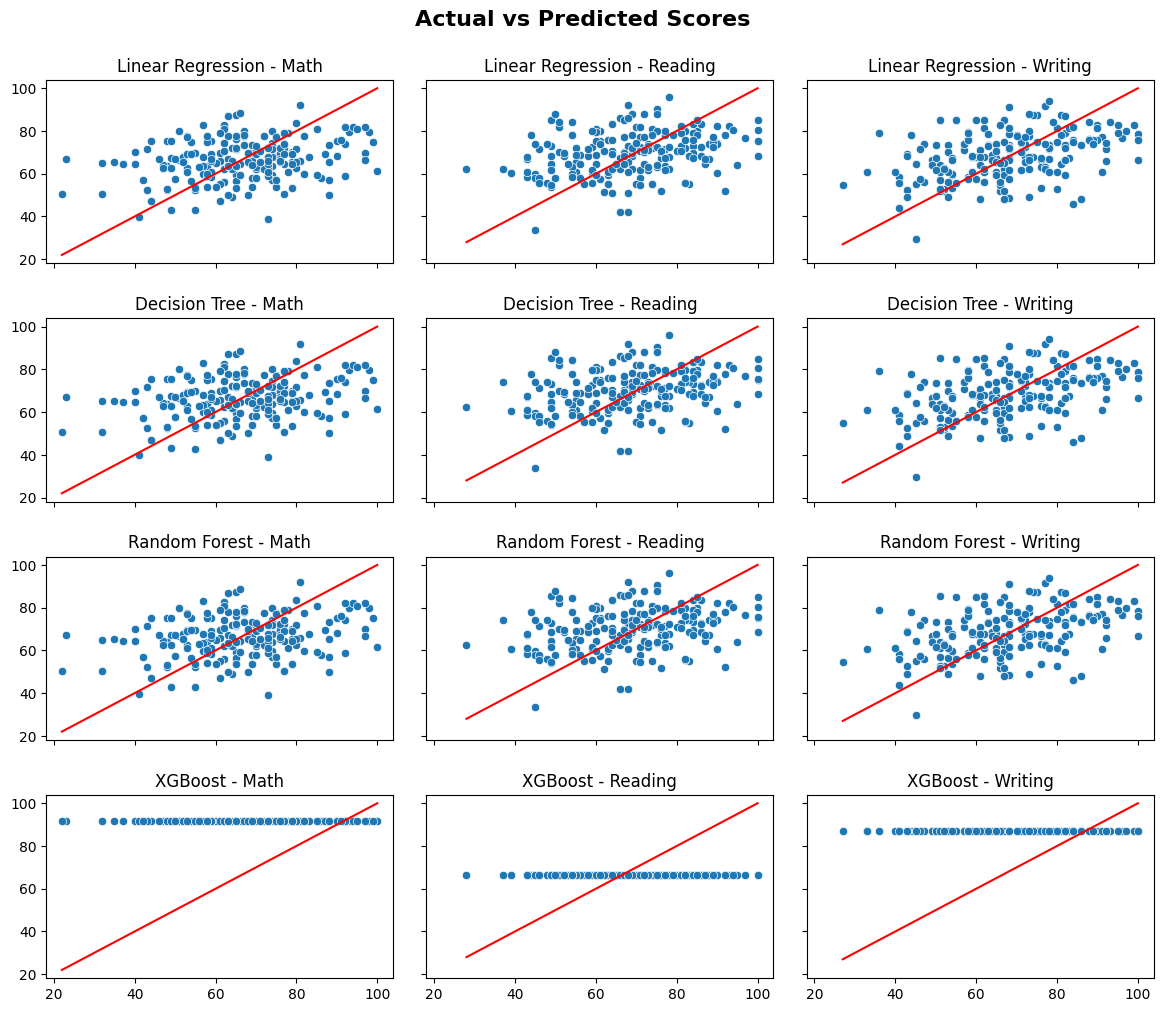

In [74]:
types = ['Math', 'Reading', 'Writing']
methods = {'lr':'Linear Regression','dt':'Decision Tree','rf':'Random Forest','xgb':'XGBoost'}

fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(12, 10), sharex=True, sharey=True)

for index, (m,n) in enumerate(methods.items()):
    for i,name in enumerate(types):
        y_var = globals()[f'pred_{m}'][i]
        sns.scatterplot(x=y_val[i], y=y_var, ax=ax[index,i])
        min_val = min(y_val[i].min(), y_var.min())
        max_val = max(y_val[i].max(), y_var.max())
        line = np.linspace(min_val, max_val, 2)
        ax[index,i].plot(line, line, color='red')
        ax[index,i].set_title(f'{n} - {name}')

fig.tight_layout(pad=2.0) 
fig.suptitle("Actual vs Predicted Scores", fontsize=16, y=1.02, fontweight='bold')

plt.show()

# Evaluation

In [75]:
# Apply appropriate evaluation metrics to measure performance

#rmse = []
#rmse.append(np.sqrt(mean_squared_error(y_pred, y_val)))